In [1]:
from urllib import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num = 1, block_size = 1, total_size = None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit = 'B', unit_scale = True, miniters = 1, desc = dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

In [2]:
import collections
import numpy as np
import random

def build_dataset(words, vocabulary_size):
    count = []
    count.extend(collections.Counter(words).most_common(vocabulary_size))

    dictionary = dict()
    for word, _ in count:
        #simply add dictionary of word, used frequently placed top
        dictionary[word] = len(dictionary)

    data = []
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]

        data.append(index)
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, reverse_dictionary

def generate_batch_skipgram(words, batch_size, num_skips, skip_window):
    data_index = 0
    
    #check batch_size able to convert into number of skip in skip-grams method
    assert batch_size % num_skips == 0
    
    assert num_skips <= 2 * skip_window
    
    # create batch for model input
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    
    # a buffer to placed skip-grams sentence
    buffer = collections.deque(maxlen=span)
    
    for i in xrange(span):
        buffer.append(words[data_index])
        data_index = (data_index + 1) % len(words)
    
    for i in xrange(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in xrange(num_skips):
            
            while target in targets_to_avoid:
                # random a word from the sentence
                # if random word still a word already chosen, simply keep looping
                target = random.randint(0, span - 1)
            
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        
        buffer.append(words[data_index])
        data_index = (data_index + 1) % len(words)
    
    data_index = (data_index + len(words) - span) % len(words)
    return batch, labels

In [3]:
import tensorflow as tf

class Model:
    
    def __init__(self, batch_size, dimension_size, learning_rate, vocabulary_size):
        
        self.train_inputs = tf.placeholder(tf.int32, shape = [batch_size])
        self.train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
        
        # randomly generated initial value for each word dimension, between -1.0 to 1.0
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, dimension_size], -1.0, 1.0))
        
        # find train_inputs from embeddings
        embed = tf.nn.embedding_lookup(embeddings, self.train_inputs)
        
        # estimation for not normalized dataset
        self.nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, dimension_size], stddev = 1.0 / np.sqrt(dimension_size)))
        
        # each node have their own bias
        self.nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
        
        # calculate loss from nce, then calculate mean
        self.loss = tf.reduce_mean(tf.nn.nce_loss(weights = self.nce_weights, biases = self.nce_biases, labels = self.train_labels,
                                                  inputs=embed, num_sampled = batch_size / 2, num_classes = vocabulary_size))
        
        #for a small neural network, for me, Adam works the best
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
        
        # normalize the data by simply reduce sum
        self.norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        
        # normalizing each embed
        self.normalized_embeddings = embeddings / self.norm

In [4]:
dimension = 128
skip_size = 8
skip_window = 1
num_skips = 2
iteration_train_vectors = 5000
words_real = text.split()[:5000]

In [5]:
print "Data size: " + str(len(words_real))
data, _, dictionary = build_dataset(words_real, len(words_real))

Data size: 5000


In [6]:
sess = tf.InteractiveSession()
print "Creating Word2Vec model.."
    
model = Model(dimension, dimension, 0.01, len(words_real))
sess.run(tf.global_variables_initializer())

import time

for step in xrange(iteration_train_vectors):
    last_time = time.time()
    batch_inputs, batch_labels = generate_batch_skipgram(data, dimension, num_skips, skip_window)
    feed_dict = {model.train_inputs: batch_inputs, model.train_labels: batch_labels}
        
    _, loss = sess.run([model.optimizer, model.loss], feed_dict=feed_dict)
        
    if ((step + 1) % 100) == 0:
        diff = time.time() - last_time
        print "epoch: " + str(step + 1) + ", loss: " + str(loss) + ", speed: " + str(diff) + " s / epoch"

Creating Word2Vec model..
epoch: 100, loss: 68.6735, speed: 0.010890007019 s / epoch
epoch: 200, loss: 65.649, speed: 0.00938391685486 s / epoch
epoch: 300, loss: 49.3146, speed: 0.00909614562988 s / epoch
epoch: 400, loss: 12.4383, speed: 0.00872802734375 s / epoch
epoch: 500, loss: 18.66, speed: 0.0089418888092 s / epoch
epoch: 600, loss: 6.26677, speed: 0.0102450847626 s / epoch
epoch: 700, loss: 0.955894, speed: 0.00940299034119 s / epoch
epoch: 800, loss: 1.40208, speed: 0.0103161334991 s / epoch
epoch: 900, loss: 12.0527, speed: 0.00908088684082 s / epoch
epoch: 1000, loss: 7.83704, speed: 0.0097119808197 s / epoch
epoch: 1100, loss: 1.27716, speed: 0.00973010063171 s / epoch
epoch: 1200, loss: 19.1743, speed: 0.0107960700989 s / epoch
epoch: 1300, loss: 1.17872, speed: 0.00912880897522 s / epoch
epoch: 1400, loss: 1.71371, speed: 0.00901889801025 s / epoch
epoch: 1500, loss: 1.26792, speed: 0.00916504859924 s / epoch
epoch: 1600, loss: 8.10185, speed: 0.0101981163025 s / epoch
e

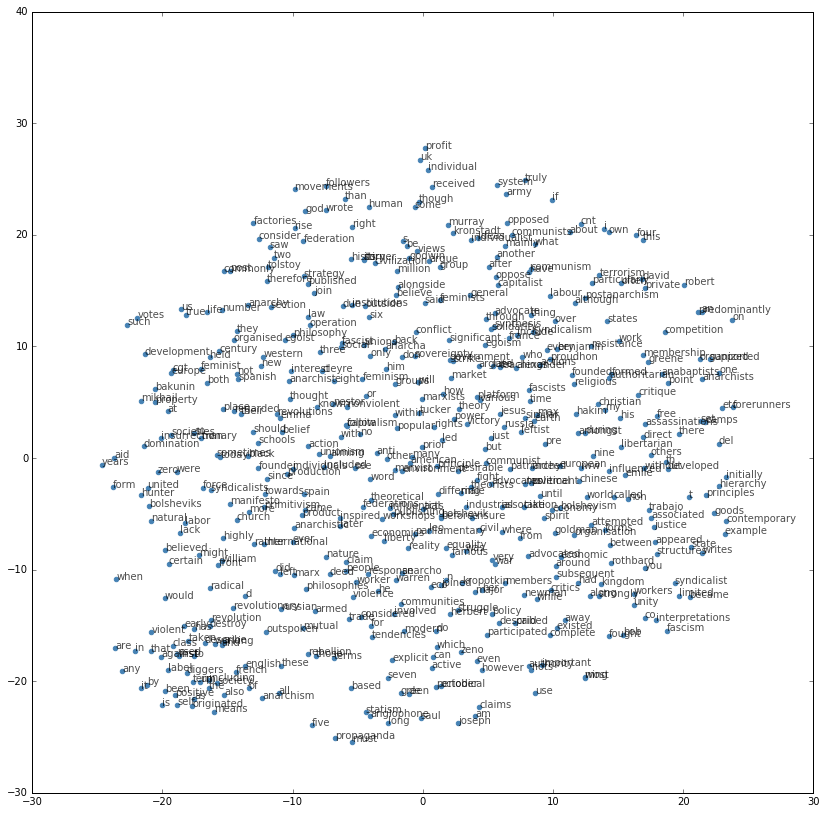

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embed_mat = sess.run(model.normalized_embeddings)
embed_tsne = TSNE().fit_transform(embed_mat[:500, :])
labels = [dictionary[i] for i in xrange(500)]
fig, ax = plt.subplots(figsize = (14, 14))
for idx in range(500):
    plt.scatter(embed_tsne[idx, 0], embed_tsne[idx, 1], color = 'steelblue')
    plt.annotate(labels[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha = 0.7)
    
plt.show()